In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
from omegaconf import OmegaConf
import numpy as np
import pandas as pd
import torch

In [3]:
path_to_root = "/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage"
os.chdir(path_to_root)

In [4]:
sys.path.append(os.path.join(path_to_root, 'code'))

In [27]:
from model.utils import analyze_runs as ar
from model.dataset.landmark_dataset import LandmarkDataset
from model.utils.utils import load_config, load_obj
from model.utils.inference import InferenceEngine
from model.utils.evaluate import EvaluationMetrics
from model.utils.path_utils import get_data_paths

# Collate Run Results

Main DF:
- run name
- best epoch
- best train loss
- best val loss
- total epochs
- final train loss
- final val loss
- model
- position
- angles
- differences
- distances
- metadata
- p_rotate
- p_noise










In [14]:
run_dir = "/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/modelling/runs"

In [15]:
results_list = []
for run_name in os.listdir(run_dir):
    print(run_name)
    if run_name == 'runs':
        continue
    results = ar.make_results_row(run_dir, run_name)
    results_list.append(results)

20250629_122716_Transformer
20250627_050944_LSTM
20250630_002957_LSTM
20250628_063313_Transformer
20250629_064332_RNN


In [45]:
pd.DataFrame(results_list)


,run_name,total_epochs,best_epoch,best_train_loss,best_val_loss,final_epoch,final_train_loss,final_val_loss,model,position,angles,differences,distances,metadata,p_rotate,p_noise
0,20250629_122716_Transformer,113,93,0.158505,0.033074,113,0.183682,0.041597,TransformerClassifier,False,True,True,True,True,0.5,0.5
1,20250627_050944_LSTM,79,59,0.034133,0.016371,79,0.037359,0.018009,LSTMClassifier,True,True,True,True,True,0.5,0.5
2,20250630_002957_LSTM,96,76,0.094698,0.012213,96,0.166336,0.017588,LSTMClassifier,False,True,True,True,True,0.5,0.5
3,20250628_063313_Transformer,121,120,0.023363,0.006599,121,0.021375,0.007308,TransformerClassifier,True,True,True,True,True,0.5,0.5
4,20250629_064332_RNN,79,59,0.038081,0.020182,79,0.042610,0.023317,RNNClassifier,True,True,True,True,True,0.5,0.5


# Test Best Models

Add on:
- sample acc
- sample acc topk
- series_majority acc
- series_logits acc
- series_confidence acc
- sample loss
- series_majority loss
- series_logits loss
- series_confidence loss

In [36]:
class_names = ar.load_class_names(os.path.join(path_to_root, "modelling", "metadata", "label_encoding_v4.json"))

In [37]:
run_name = '20250627_050944_LSTM copy'

In [38]:
model_dir = os.path.join(run_dir, run_name)
model = ar.load_model(model_dir, model_name="checkpoint.pt")
train_dataset = ar.create_dataset_without_augmentations(model_dir, "train")
test_dataset = ar.create_dataset_without_augmentations(model_dir, "test", seed=42)

In [39]:
train_results = ar.test_model_on_dataset(model, train_dataset, class_names)

Loading inference engines...
Running sample inference...
Done (37.987627267837524 seconds)


In [40]:
train_results

{'sample_acc': 1.0,
 'sample_loss': 2.3020901679992676,
 'sample_topk_acc_2': 1.0,
 'sample_topk_acc_3': 1.0,
 'sample_topk_acc_4': 1.0,
 'sample_topk_acc_5': 1.0}

In [41]:
test_results = ar.test_model_on_dataset(model, test_dataset, class_names, majority_ensemble=True, logits_ensemble=True, confidence_ensemble=True)

Loading inference engines...
Running sample inference...
Running majority ensemble inference...
FYI: Full probabilities represent normalized vote counts for each class (num_votes_for_class / total_votes)
Running logits ensemble inference...
FYI: Full probabilities represent the softmax distribution from averaged logits across all samples
Running confidence ensemble inference...
FYI: Full probabilities represent weighted sum of each sample's probabilities, weighted by their confidence
Done (32.604812145233154 seconds)


In [42]:
test_results

{'sample_acc': 0.6371681415929203,
 'sample_loss': 2.693714141845703,
 'sample_topk_acc_2': 0.7522123893805309,
 'sample_topk_acc_3': 0.8495575221238938,
 'sample_topk_acc_4': 0.9380530973451328,
 'sample_topk_acc_5': 0.9557522123893806,
 'majority_acc': 0.6,
 'majority_loss': 2.656366504643752,
 'logits_acc': 0.64,
 'logits_loss': 2.702709913253784,
 'confidence_acc': 0.6,
 'confidence_loss': 2.709162950515747}

Train, Val

In [29]:
cv_datasets = ar.create_cross_validation_datasets(train_dataset, 120)
cv_datasets

{0: (<torch.utils.data.dataset.Subset at 0x7fc43a18dfd0>,
  <torch.utils.data.dataset.Subset at 0x7fc439ea7d10>),
 1: (<torch.utils.data.dataset.Subset at 0x7fc439fe59d0>,
  <torch.utils.data.dataset.Subset at 0x7fc439ffb4d0>),
 2: (<torch.utils.data.dataset.Subset at 0x7fc439ff8950>,
  <torch.utils.data.dataset.Subset at 0x7fc439d7d6d0>),
 3: (<torch.utils.data.dataset.Subset at 0x7fc439d7e610>,
  <torch.utils.data.dataset.Subset at 0x7fc439d7f4d0>),
 4: (<torch.utils.data.dataset.Subset at 0x7fc439d7c290>,
  <torch.utils.data.dataset.Subset at 0x7fc439d7fd10>)}

In [30]:
for train,val in cv_datasets.values():
    print(len(train), len(val))

450 114
458 106
444 120
451 113
453 111


In [31]:
avg_results, train_results, val_results = ar.test_model_on_cross_validation_datasets(model, cv_datasets, class_names)
avg_results

- Fold 1 -
Loading inference engines...
Running sample inference...
Done (28.186978101730347 seconds)
Loading inference engines...
Running sample inference...
Done (7.828782796859741 seconds)
- Fold 2 -
Loading inference engines...
Running sample inference...
Done (28.481027841567993 seconds)
Loading inference engines...
Running sample inference...
Done (7.464059114456177 seconds)
- Fold 3 -
Loading inference engines...
Running sample inference...
Done (36.74887943267822 seconds)
Loading inference engines...
Running sample inference...
Done (8.463491201400757 seconds)
- Fold 4 -
Loading inference engines...
Running sample inference...
Done (29.456141233444214 seconds)
Loading inference engines...
Running sample inference...
Done (9.021097898483276 seconds)
- Fold 5 -
Loading inference engines...
Running sample inference...
Done (35.46231174468994 seconds)
Loading inference engines...
Running sample inference...
Done (5.780415296554565 seconds)


{'train_acc': 1.0,
 'train_loss': 2.291715669631958,
 'val_acc': 1.0,
 'val_loss': 2.2917105197906493}

Slightly different, because in training, the model weights are updated within each batch within each fold

In [32]:
{key: value['sample_loss'] for key, value in train_results.items()}

{0: 2.2919130325317383,
 1: 2.2918620109558105,
 2: 2.291673183441162,
 3: 2.2916219234466553,
 4: 2.291508197784424}

In [33]:
{key: value['sample_loss'] for key, value in val_results.items()}

{0: 2.290938377380371,
 1: 2.2910842895507812,
 2: 2.2918741703033447,
 3: 2.2920913696289062,
 4: 2.2925643920898438}

In [ ]:
{key: value['sample_loss'] for key, value in train_results.items()}

{0: 3.2185580730438232,
 1: 3.2185943126678467,
 2: 3.2188351154327393,
 3: 3.218813419342041,
 4: 3.2186532020568848}

In [ ]:
{key: value['sample_loss'] for key, value in val_results.items()}

{0: 3.219181776046753,
 1: 3.2191202640533447,
 2: 3.21811842918396,
 3: 3.2181901931762695,
 4: 3.2188360691070557}

Model from end of epoch 0, test dataset from end of epoch 0

In [35]:
test_results = ar.test_model_on_dataset(model, test_dataset, class_names)

Loading inference engines...
Running sample inference...
Done (3.6060662269592285 seconds)


In [36]:
test_results

{'sample_acc': 0.04424778761061947,
 'sample_loss': 3.218918561935425,
 'sample_topk_acc_2': 0.05309734513274336,
 'sample_topk_acc_3': 0.10619469026548672,
 'sample_topk_acc_4': 0.1504424778761062,
 'sample_topk_acc_5': 0.21238938053097345}

Results are the same

## Development

23/07
Function below gets same result as cells above

{'general': {'experiment_name': None, 'author': None}, 'optimizer': {'class_name': 'torch.optim.AdamW', 'params': {'lr': '${training.lr}', 'weight_decay': 0.001}}, 'scheduler': {'class_name': 'torch.optim.lr_scheduler.ReduceLROnPlateau', 'params': {'mode': 'min', 'factor': 0.1, 'patience': 3}}, 'model': {'class_name': 'model.models.transformers.TransformerClassifier', 'params': {'num_classes': 25, 'd_model': 128, 'nhead': 8, 'num_layers': 2, 'dim_feedforward': 256, 'dropout': 0.1, 'input_size': 339}}, 'dataset': {'data_version': 'v4', 'frame_sampling_train': {'enabled': True, 'method': 'multiple_uniform', 'params': {'frames_per_sample': 20, 'num_samples_limit': 5, 'replacement_rate': 0.2, 'include_remaining': True}}, 'frame_sampling_test': {'method': 'multiple_uniform', 'params': {'frames_per_sample': 20, 'num_samples_limit': 5, 'replacement_rate': 0.2, 'include_remaining': True}}, 'landmark_types': ['pose', 'right_hand', 'left_hand'], 'ordering': ['features', 'landmark_types'], 'paths

/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Running majority ensemble inference...
FYI: Full probabilities represent normalized vote counts for each class (num_votes_for_class / total_votes)
Running logits ensemble inference...
FYI: Full probabilities represent the softmax distribution from averaged logits across all samples
Running confidence ensemble inference...
FYI: Full probabilities represent weighted sum of each sample's probabilities, weighted by their confidence
Done (28.630324125289917 seconds)
Saved test results to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/modelling/runs/20250628_063313_Transformer/test_results.json
Saved plots to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/modelling/runs/20250628_063313_Transformer


({'sample_acc': 0.6017699115044248,
  'sample_loss': 2.6952834129333496,
  'sample_topk_acc_2': 0.8141592920353983,
  'sample_topk_acc_3': 0.8672566371681416,
  'sample_topk_acc_4': 0.9026548672566371,
  'sample_topk_acc_5': 0.911504424778761,
  'majority_acc': 0.6,
  'majority_loss': 2.6805574656155824,
  'logits_acc': 0.6,
  'logits_loss': 2.699367046356201,
  'confidence_acc': 0.6,
  'confidence_loss': 2.7046141624450684},
 <model.utils.evaluate.EvaluationMetrics at 0x7f552d03fbd0>)

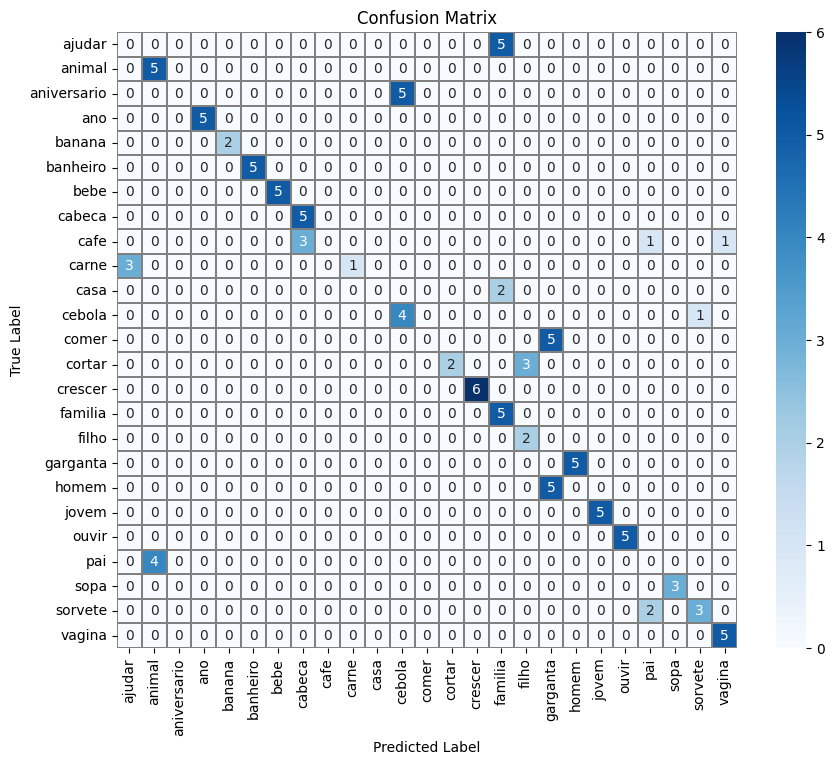

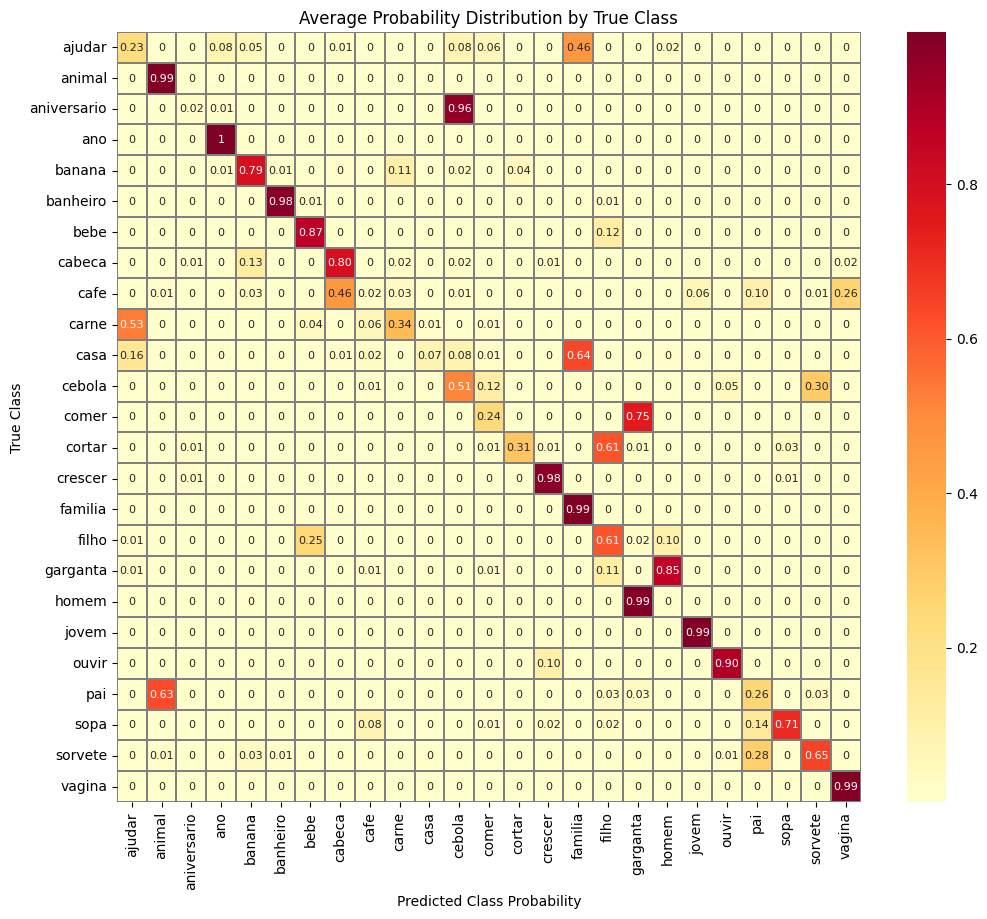

In [44]:
evaluate_model_from_run(
    '/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/modelling/runs/20250628_063313_Transformer',
    'cpu',
    True
)

In [34]:
def evaluate_model_from_run(run_dir: str, device: str = 'cuda', save_outputs: bool = True):
    """
    Evaluate a trained model from an existing run directory.
    
    Args:
        run_dir (str): Path to the run directory containing config.yaml and best_model.pt
        device (str): Device to run evaluation on ('cuda' or 'cpu')
        save_outputs (bool): Whether to save test results and plots to the run directory
        
    Returns:
        tuple: (test_results, eval_obj) containing evaluation metrics and visualization object
    """
    # Load config
    config_path = os.path.join(run_dir, "config.yaml")
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"No config.yaml found in {run_dir}")
    config = OmegaConf.load(config_path)
    print(config)
    config.model.params.device = device
    print(config)
    if 'device' in config.model.params:
        del config.model.params['device']
    print(config)
    # Load model
    model = load_obj(config.model.class_name)(**config.model.params)
    model.to(device)
    
    # Load best model weights
    best_model_path = os.path.join(run_dir, "best_model.pt")
    if not os.path.exists(best_model_path):
        raise FileNotFoundError(f"No best_model.pt found in {run_dir}")
    checkpoint = torch.load(best_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Create test dataset
    test_dataset = LandmarkDataset(
        config.dataset, config.features, config.augmentation, "test", seed=42
    )
    
    # Load label mapping
    label_mapping_path = "/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/modelling/metadata/label_encoding_v4.json"
    with open(label_mapping_path, "r") as f:
        label_encoding = json.load(f)
    class_names = [label_encoding[str(i)] for i in range(len(label_encoding))]
    
    # Run evaluation
    test_results, eval_obj = ar.test_model_on_dataset(
        model, test_dataset, class_names, device, model_name="best_model.pt",
        majority_ensemble=True, logits_ensemble=True, confidence_ensemble=True, return_eval=True
    )
    
    if save_outputs:
        # Save test results
        results_path = os.path.join(run_dir, "test_results.json")
        with open(results_path, "w") as f:
            json.dump(test_results, f)
        print(f"Saved test results to {results_path}")
        
        # Save plots
        eval_obj.plot_confusion_matrix(save_path=os.path.join(run_dir, "confusion_matrix.png"))
        eval_obj.plot_probability_heatmap(save_path=os.path.join(run_dir, "probability_heatmap.png"))
        print(f"Saved plots to {run_dir}")
    
    return test_results, eval_obj


Load Config

In [13]:
model_dir = os.path.join(run_dir, run_name)
config_path = os.path.join(model_dir, "config.yaml")
config = OmegaConf.load(config_path)

Load Datasets (with no augmentation)

In [14]:
for k, v in config.items():
    print(k)
    for k2, v2 in v.items():
        print(f'\t{k2}: {v2}')

general
	experiment_name: None
	author: None
optimizer
	class_name: torch.optim.AdamW
	params: {'lr': '${training.lr}', 'weight_decay': 0.001}
scheduler
	class_name: torch.optim.lr_scheduler.ReduceLROnPlateau
	params: {'mode': 'min', 'factor': 0.1, 'patience': 3}
model
	class_name: model.models.rnn_classifiers.RNNClassifier
	params: {'hidden_size': 256, 'num_layers': 2, 'num_classes': 25, 'input_size': 189}
dataset
	data_version: v4
	frame_sampling_train: {'enabled': True, 'method': 'multiple_uniform', 'params': {'frames_per_sample': 20, 'num_samples_limit': 5, 'replacement_rate': 0.2, 'include_remaining': True}}
	frame_sampling_test: {'method': 'multiple_uniform', 'params': {'frames_per_sample': 20, 'num_samples_limit': 5, 'replacement_rate': 0.2, 'include_remaining': True}}
	landmark_types: ['pose', 'right_hand', 'left_hand']
	ordering: ['features', 'landmark_types']
	paths: {'preprocessed_base': 'data/preprocessed', 'metadata_base': 'modelling/metadata', 'logs_base': '../drive/MyDri

In [15]:
metadata_path = os.path.join(
    path_to_root,
    "modelling",
    "metadata",
    )
training_metadata = pd.read_csv(os.path.join(metadata_path, f"landmarks_metadata_{config.dataset.data_version}_training.csv"))
with open(os.path.join(metadata_path, "label_encoding.json"), "r") as f:
    label_encoding = json.load(f)
class_names = [label_encoding[str(i)] for i in range(len(label_encoding))]

In [16]:
class_names

['banana',
 'sopa',
 'garganta',
 'café',
 'aniversário',
 'vagina',
 'animal',
 'cortar',
 'carne',
 'jovem',
 'casa',
 'banheiro',
 'cebola',
 'sorvete',
 'homem',
 'ajudar',
 'crescer',
 'família',
 'cabeça',
 'pai',
 'ano',
 'comer',
 'ouvir',
 'bebê',
 'filho']

In [19]:
augmentations = {
    "train": None,
    "test": None,
}

train_dataset = LandmarkDataset(
    config.dataset, config.features, augmentations, "train"
)
test_dataset = LandmarkDataset(
    config.dataset, config.features, augmentations, "test"
)

In [20]:
len(train_dataset), len(test_dataset)

(563, 113)

Load Model

In [21]:
checkpoint_path = os.path.join(model_dir, "best_model.pt")
checkpoint = torch.load(checkpoint_path, map_location='cpu')
model = load_obj(config.model.class_name)(**config.model.params)
model.load_state_dict(checkpoint['model_state_dict'])
model.to('cpu')

RNNClassifier(
  (rnn): GRU(189, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=25, bias=True)
)

Inference

In [22]:
sample_inference = InferenceEngine(
    model=model,
    device='cpu',
    ensemble_strategy=None
)
majority_inference = InferenceEngine(
    model=model,
    device='cpu',
    ensemble_strategy='majority'
)
logits_inference = InferenceEngine(
    model=model,
    device='cpu',
    ensemble_strategy='logits_average'
)
confidence_inference = InferenceEngine(
    model=model,
    device='cpu',
    ensemble_strategy='confidence_weighted'
)

In [23]:
sample_train_preds, sample_train_labels, sample_train_probs = sample_inference.predict(train_dataset, return_labels=True, return_full_probs=True)

In [28]:
majority_train_output = majority_inference.predict(train_dataset, return_labels=True, return_full_probs=True)
majority_train_preds, majority_train_labels, majority_train_probs = [np.array(x) for x in zip(*majority_train_output.values())]

Full probabilities represent normalized vote counts for each class (num_votes_for_class / total_votes)


In [19]:
logits_train_output = logits_inference.predict(train_dataset, return_labels=True, return_full_probs=True)
logits_train_preds, logits_train_labels, logits_train_probs = [np.array(x) for x in zip(*logits_train_output.values())]

In [20]:
confidence_train_output = confidence_inference.predict(train_dataset, return_labels=True, return_full_probs=True)
confidence_train_preds, confidence_train_labels, confidence_train_probs = [np.array(x) for x in zip(*confidence_train_output.values())]

In [21]:
sample_test_preds, sample_test_labels, sample_test_probs = sample_inference.predict(test_dataset, return_labels=True, return_full_probs=True)

In [70]:
majority_test_output = majority_inference.predict(test_dataset, return_labels=True, return_full_probs=True)
majority_test_preds, majority_test_labels, majority_test_probs = [np.array(x) for x in zip(*majority_test_output.values())]

In [23]:
logits_test_output = logits_inference.predict(test_dataset, return_labels=True, return_full_probs=True)
logits_test_preds, logits_test_labels, logits_test_probs = [np.array(x) for x in zip(*logits_test_output.values())]

In [24]:
confidence_test_output = confidence_inference.predict(test_dataset, return_labels=True, return_full_probs=True)
confidence_test_preds, confidence_test_labels, confidence_test_probs = [np.array(x) for x in zip(*confidence_test_output.values())]

Evaluate

In [58]:
label_encoding

{'15': 'ajudar',
 '6': 'animal',
 '4': 'aniversário',
 '20': 'ano',
 '0': 'banana',
 '11': 'banheiro',
 '23': 'bebê',
 '18': 'cabeça',
 '3': 'café',
 '8': 'carne',
 '10': 'casa',
 '12': 'cebola',
 '21': 'comer',
 '7': 'cortar',
 '16': 'crescer',
 '17': 'família',
 '24': 'filho',
 '2': 'garganta',
 '14': 'homem',
 '9': 'jovem',
 '22': 'ouvir',
 '19': 'pai',
 '1': 'sopa',
 '13': 'sorvete',
 '5': 'vagina'}

In [25]:
label_decoding = {v: k for k, v in label_encoding.items()}

In [26]:
label_decoding

{'ajudar': '15',
 'animal': '6',
 'aniversário': '4',
 'ano': '20',
 'banana': '0',
 'banheiro': '11',
 'bebê': '23',
 'cabeça': '18',
 'café': '3',
 'carne': '8',
 'casa': '10',
 'cebola': '12',
 'comer': '21',
 'cortar': '7',
 'crescer': '16',
 'família': '17',
 'filho': '24',
 'garganta': '2',
 'homem': '14',
 'jovem': '9',
 'ouvir': '22',
 'pai': '19',
 'sopa': '1',
 'sorvete': '13',
 'vagina': '5'}

In [27]:
label_remapping = {i: int(label_decoding[label]) for i, label in enumerate(sorted(class_names))}
label_remapping

{0: 15,
 1: 6,
 2: 4,
 3: 20,
 4: 0,
 5: 11,
 6: 23,
 7: 18,
 8: 3,
 9: 8,
 10: 10,
 11: 12,
 12: 21,
 13: 7,
 14: 16,
 15: 17,
 16: 24,
 17: 2,
 18: 14,
 19: 9,
 20: 22,
 21: 19,
 22: 1,
 23: 13,
 24: 5}

In [28]:
sample_train_labels_r = [label_remapping[label] for label in sample_train_labels]
majority_train_labels_r = [label_remapping[label] for label in majority_train_labels]
logits_train_labels_r = [label_remapping[label] for label in logits_train_labels]
confidence_train_labels_r = [label_remapping[label] for label in confidence_train_labels]
sample_test_labels_r = [label_remapping[label] for label in sample_test_labels]
majority_test_labels_r = [label_remapping[label] for label in majority_test_labels]
logits_test_labels_r = [label_remapping[label] for label in logits_test_labels]
confidence_test_labels_r = [label_remapping[label] for label in confidence_test_labels]

In [ ]:
sample_train_eval = EvaluationMetrics(
    sample_train_preds,
    sample_train_labels,
    sample_train_probs,
    num_classes=25,
    class_names=class_names
)

majority_train_eval = EvaluationMetrics(
    majority_train_preds,
    majority_train_labels,
    majority_train_probs,
    num_classes=25,
    class_names=class_names
)

logits_train_eval = EvaluationMetrics(
    logits_train_preds,
    logits_train_labels,
    logits_train_probs,
    num_classes=25,
    class_names=class_names
)

confidence_train_eval = EvaluationMetrics(
    confidence_train_preds,
    confidence_train_labels,
    confidence_train_probs,
    num_classes=25,
    class_names=class_names
)

sample_test_eval = EvaluationMetrics(
    sample_test_preds,
    sample_test_labels,
    sample_test_probs,
    num_classes=25,
    class_names=class_names
)

majority_test_eval = EvaluationMetrics(
    majority_test_preds,
    majority_test_labels,
    majority_test_probs,
    num_classes=25,
    class_names=class_names
)

logits_test_eval = EvaluationMetrics(
    logits_test_preds,
    logits_test_labels,
    logits_test_probs,
    num_classes=25,
    class_names=class_names
)

confidence_test_eval = EvaluationMetrics(
    confidence_test_preds,
    confidence_test_labels,
    confidence_test_probs,
    num_classes=25,
    class_names=class_names
)

In [26]:
sample_train_eval.accuracy

0.04262877442273535

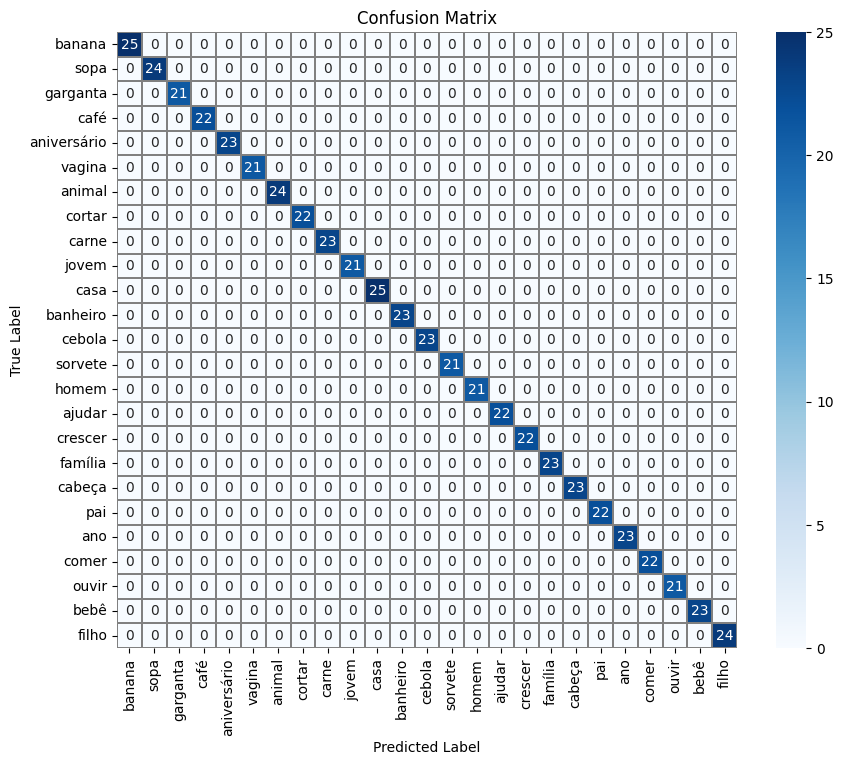

In [31]:
sample_train_eval.plot_confusion_matrix()

In [32]:
majority_train_eval.accuracy

1.0

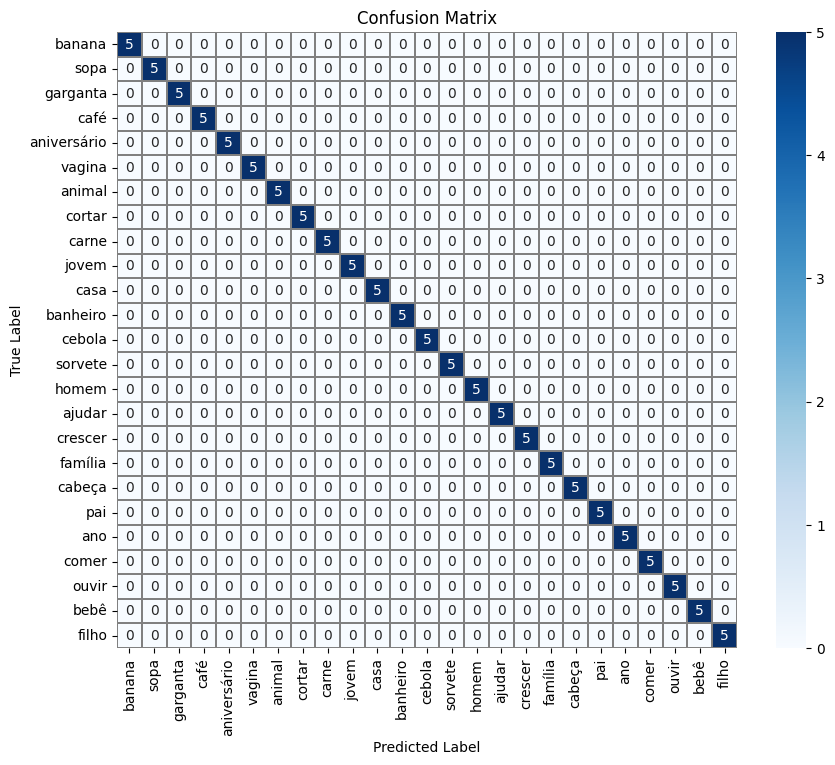

In [33]:
majority_train_eval.plot_confusion_matrix()

In [34]:
logits_train_eval.accuracy

1.0

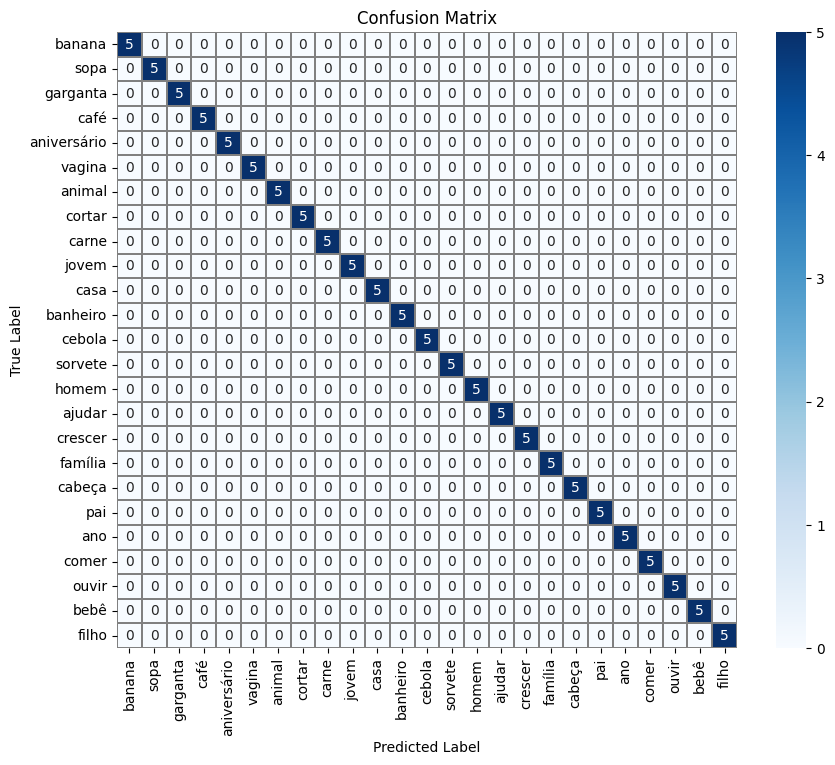

In [35]:
logits_train_eval.plot_confusion_matrix()

In [36]:
confidence_train_eval.get_accuracy()

1.0

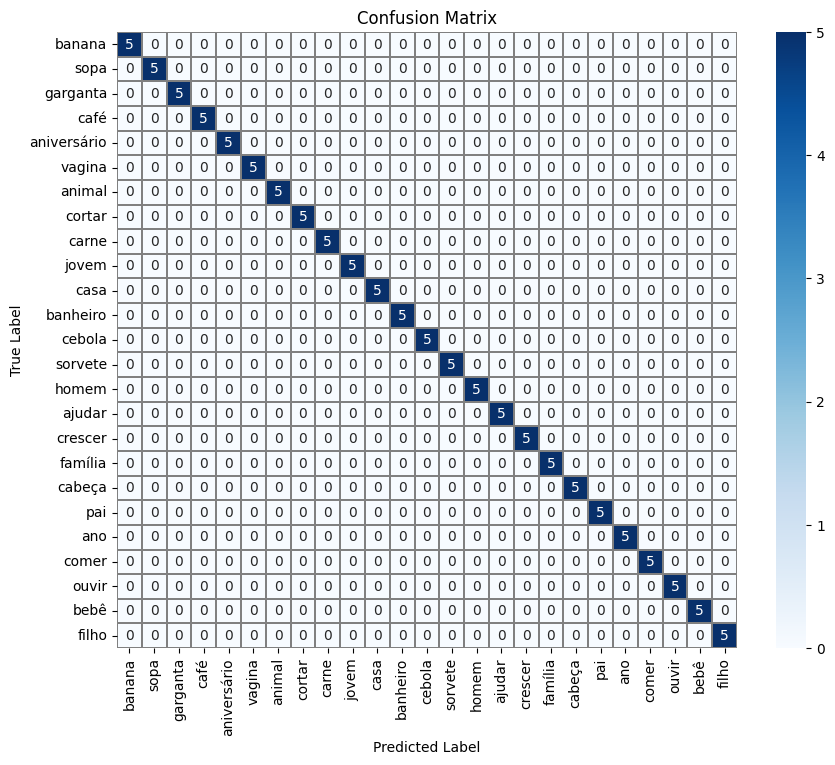

In [37]:
confidence_train_eval.plot_confusion_matrix()

In [38]:
sample_test_eval.accuracy

0.5178571428571429

In [54]:
sample_test_eval.get_loss(torch.nn.CrossEntropyLoss())

2.777400493621826

In [76]:
sample_test_eval.class_metrics

{0: {'precision': 0.3333333333333333, 'recall': 1.0, 'f1': 0.5, 'support': 2},
 1: {'precision': 0, 'recall': 0.0, 'f1': 0, 'support': 3},
 2: {'precision': 0.0, 'recall': 0.0, 'f1': 0, 'support': 5},
 3: {'precision': 0.1, 'recall': 0.2, 'f1': 0.13333333333333333, 'support': 5},
 4: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'support': 5},
 5: {'precision': 0.4166666666666667,
  'recall': 1.0,
  'f1': 0.5882352941176471,
  'support': 5},
 6: {'precision': 1.0, 'recall': 0.4, 'f1': 0.5714285714285715, 'support': 5},
 7: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'support': 5},
 8: {'precision': 0.0, 'recall': 0.0, 'f1': 0, 'support': 4},
 9: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'support': 5},
 10: {'precision': 0, 'recall': 0.0, 'f1': 0, 'support': 2},
 11: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'support': 5},
 12: {'precision': 0, 'recall': 0.0, 'f1': 0, 'support': 5},
 13: {'precision': 0.625,
  'recall': 1.0,
  'f1': 0.7692307692307693,
  'support': 5},
 14: {'prec

In [74]:
print(sample_test_eval.get_classification_report())

              precision    recall  f1-score   support

      banana     0.3333    1.0000    0.5000         2
        sopa     0.0000    0.0000    0.0000         3
    garganta     0.0000    0.0000    0.0000         5
        café     0.1000    0.2000    0.1333         5
 aniversário     1.0000    1.0000    1.0000         5
      vagina     0.4167    1.0000    0.5882         5
      animal     1.0000    0.4000    0.5714         5
      cortar     1.0000    1.0000    1.0000         5
       carne     0.0000    0.0000    0.0000         4
       jovem     1.0000    1.0000    1.0000         5
        casa     0.0000    0.0000    0.0000         2
    banheiro     1.0000    1.0000    1.0000         5
      cebola     0.0000    0.0000    0.0000         5
     sorvete     0.6250    1.0000    0.7692         5
       homem     0.0000    0.0000    0.0000         5
      ajudar     0.0000    0.0000    0.0000         5
     crescer     0.5000    0.1667    0.2500         6
     família     1.0000    

/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

In [61]:
sample_test_eval.get_error_analysis()

{'ajudar->banana': [0, 1, 2, 4],
 'ajudar->sorvete': [3],
 'animal->crescer': [6],
 'animal->vagina': [8, 9],
 'bebê->filho': [27, 29, 30, 31],
 'bebê->garganta': [28],
 'café->carne': [38, 39, 40, 41],
 'carne->café': [42, 43, 44, 45],
 'casa->ajudar': [46, 47],
 'cebola->filho': [48, 50, 51],
 'cebola->ano': [49, 52],
 'comer->sorvete': [53],
 'comer->garganta': [54],
 'comer->café': [55, 56, 57],
 'crescer->vagina': [64, 65, 66, 67, 68],
 'filho->garganta': [74, 75],
 'garganta->homem': [76, 77, 78, 79, 80],
 'homem->garganta': [81, 82, 83, 84, 85],
 'pai->sorvete': [98],
 'sopa->café': [99, 100],
 'sopa->homem': [101]}

In [69]:
np.array([1,2,3])[1]

2

In [66]:
type(majority_test_preds[0])

numpy.float64

TypeError: list indices must be integers or slices, not numpy.float64

In [39]:
for k in [1,2,3,4,5,6,7,8,9,10]:
    print(k, sample_test_eval.get_topk_accuracy(k))

1 0.5178571428571429
2 0.6339285714285714
3 0.6875
4 0.8125
5 0.875
6 0.9375
7 0.9464285714285714
8 0.9732142857142857
9 0.9821428571428571
10 0.9910714285714286


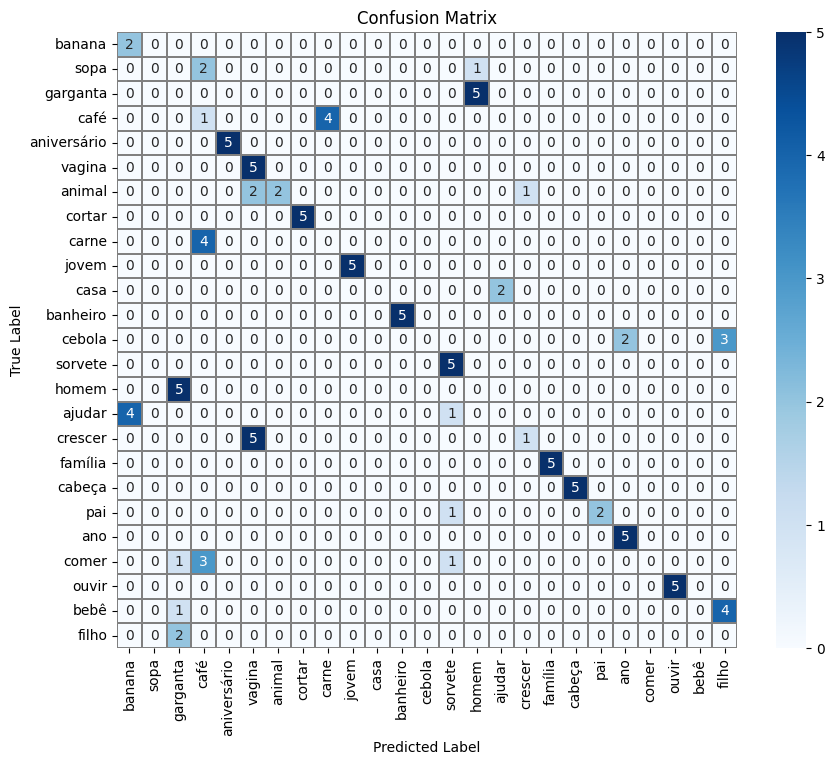

In [40]:
sample_test_eval.plot_confusion_matrix()

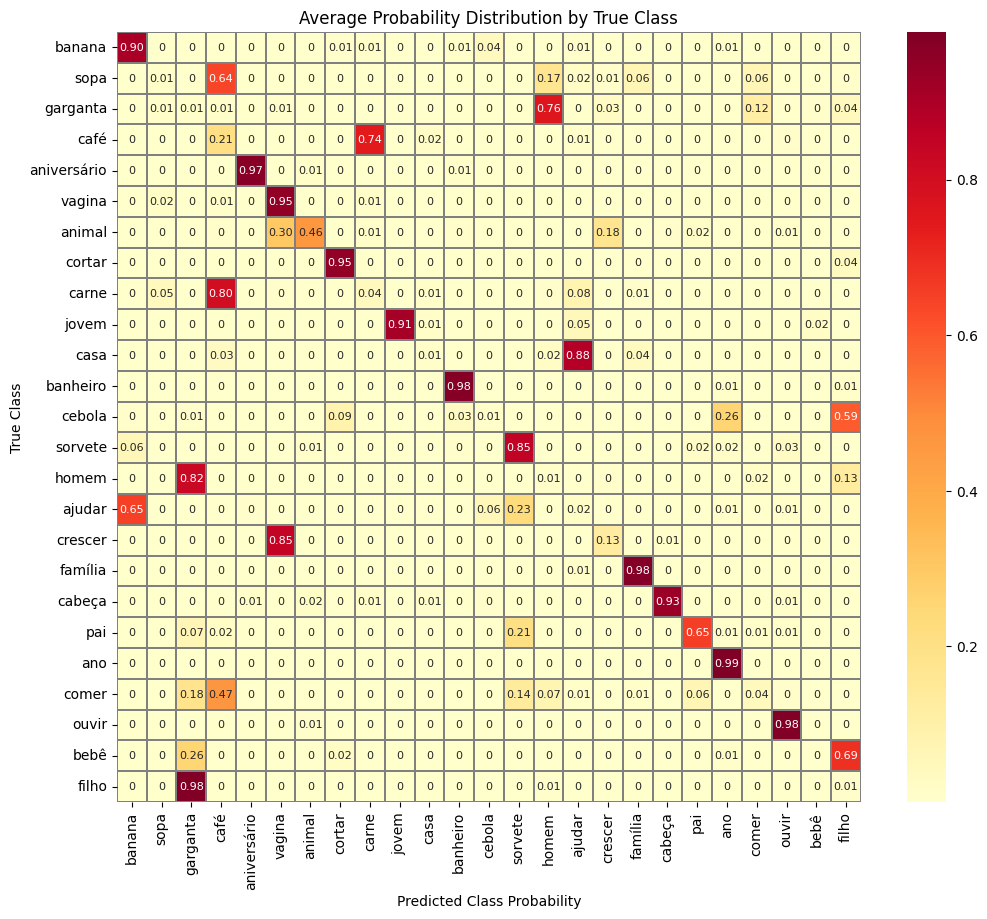

In [41]:
sample_test_eval.plot_probability_heatmap()

In [42]:
majority_test_eval.accuracy

0.48

In [56]:
majority_test_eval.get_loss(torch.nn.CrossEntropyLoss())

2.7832340866203618

In [43]:
for k in [1,2,3,4,5,6,7,8,9,10]:
    print(k, majority_test_eval.get_topk_accuracy(k))

1 0.48
2 0.64
3 0.64
4 0.64
5 0.72
6 0.72
7 0.72
8 0.72
9 0.72
10 0.76


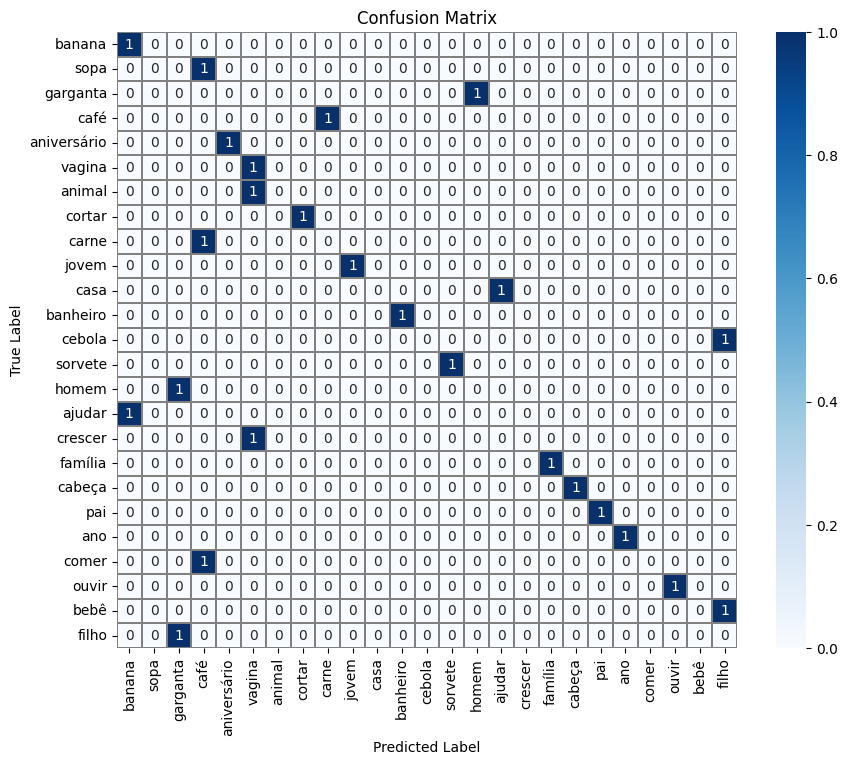

In [44]:
majority_test_eval.plot_confusion_matrix()

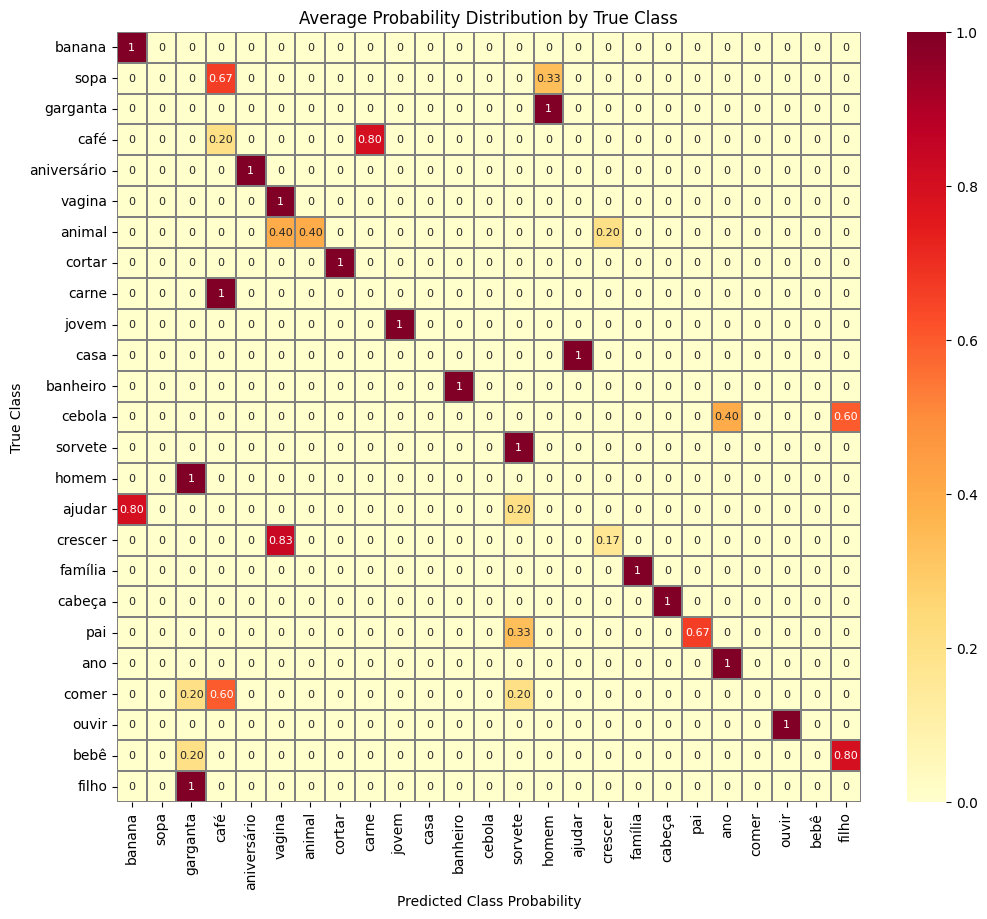

In [45]:
majority_test_eval.plot_probability_heatmap()

In [46]:
logits_test_eval.accuracy

0.52

In [57]:
logits_test_eval.get_loss(torch.nn.CrossEntropyLoss())

2.793198823928833

In [47]:
for k in [1,2,3,4,5,6,7,8,9,10]:
    print(k, logits_test_eval.get_topk_accuracy(k))

1 0.52
2 0.64
3 0.68
4 0.8
5 0.84
6 0.96
7 1.0
8 1.0
9 1.0
10 1.0


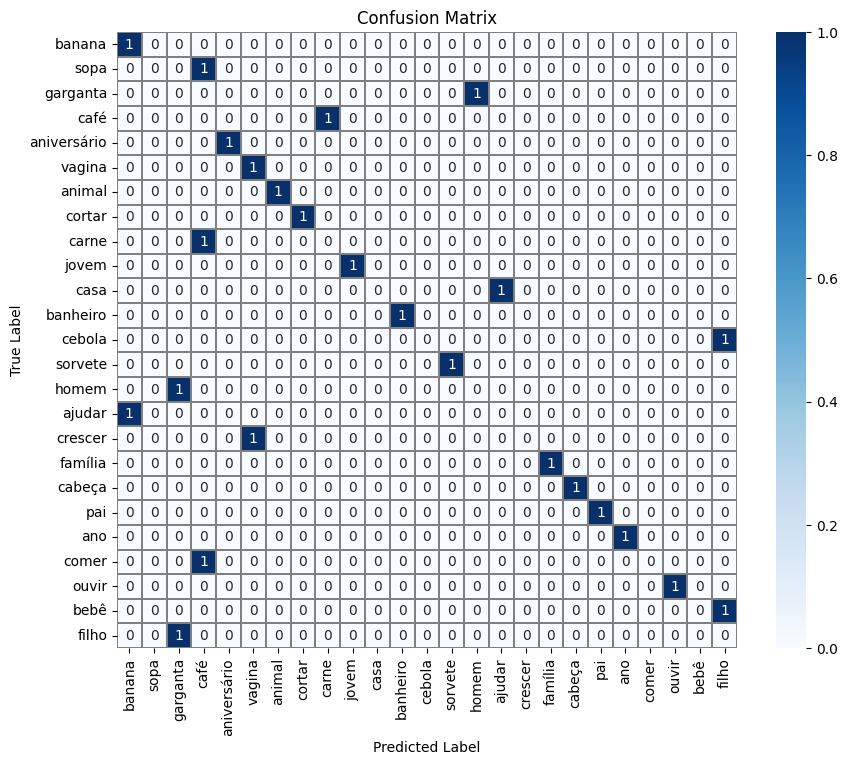

In [48]:
logits_test_eval.plot_confusion_matrix()

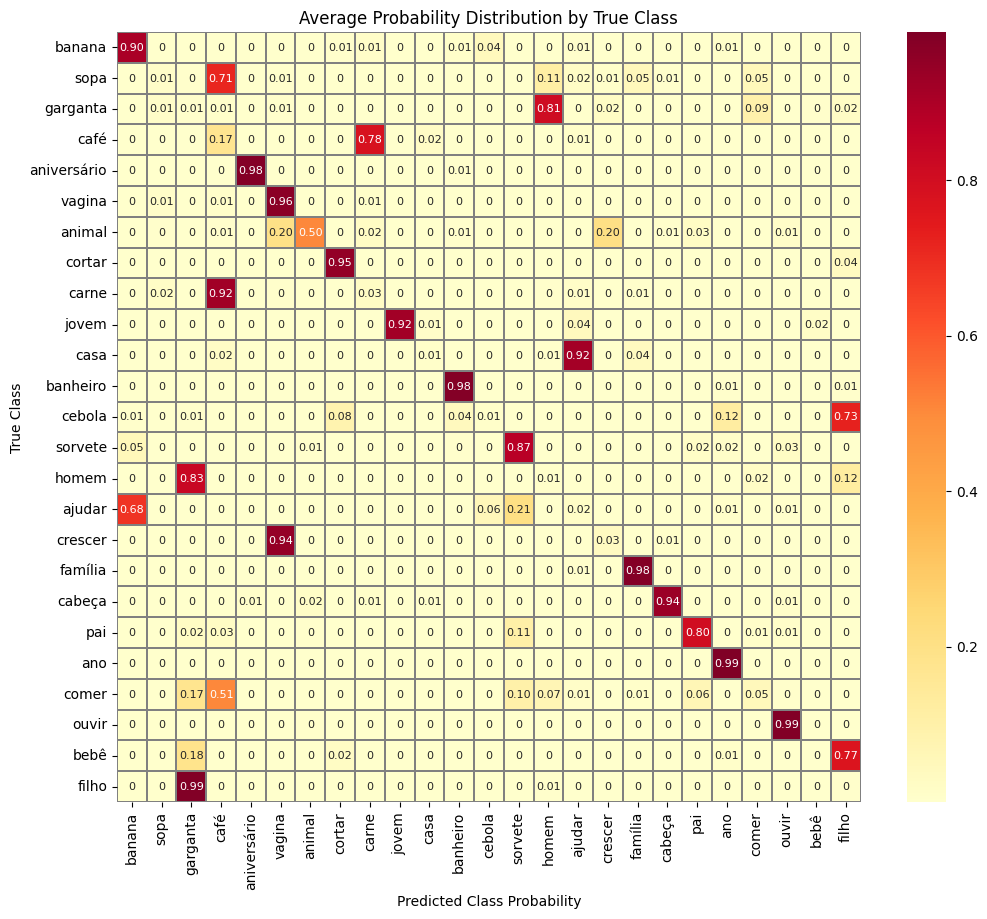

In [59]:
logits_test_eval.plot_probability_heatmap()

In [49]:
confidence_test_eval.accuracy

0.52

In [58]:
confidence_test_eval.get_loss(torch.nn.CrossEntropyLoss())

2.795719623565674

In [50]:
for k in [1,2,3,4,5,6,7,8,9,10]:
    print(k, confidence_test_eval.get_topk_accuracy(k))

1 0.52
2 0.64
3 0.68
4 0.76
5 0.88
6 0.96
7 1.0
8 1.0
9 1.0
10 1.0


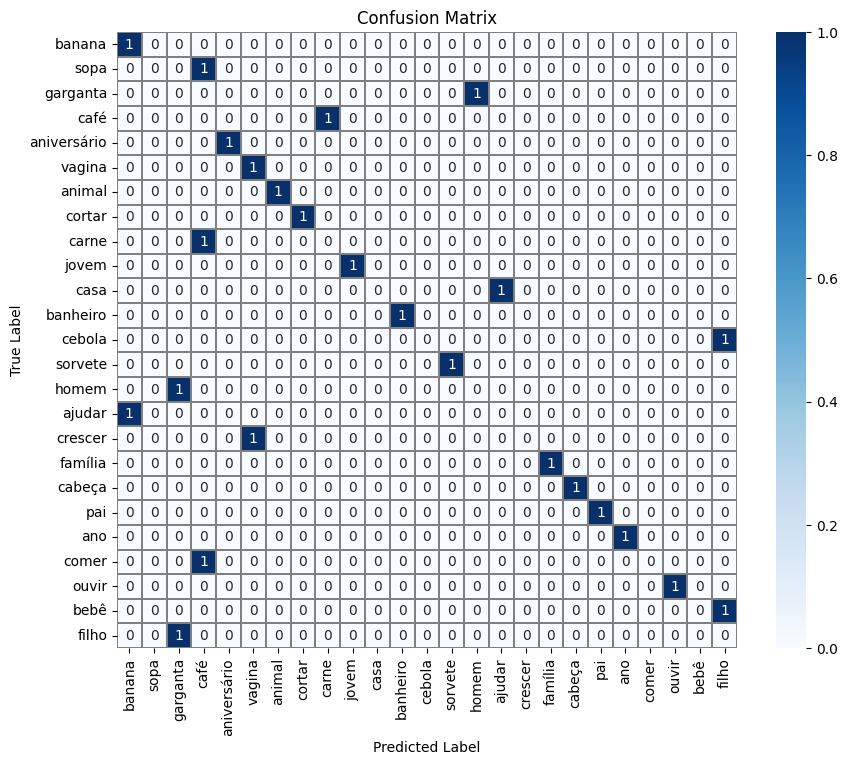

In [51]:
confidence_test_eval.plot_confusion_matrix()